# Pre-processing
Notebook to explore the pre-processing of the data.

In [175]:
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
import nltk # To download
import re
from nltk.corpus import stopwords
nltk.download('stopwords') # For stop words
nltk.download('wordnet') # For POS 
nltk.download('averaged_perceptron_tagger') # For POS tagging
stop_words = set(stopwords.words('english'))
stop_words.add('')
stop_words.remove('no')
stop_words.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adelliinaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adelliinaa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adelliinaa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [176]:
data = pd.read_csv('../data/stanfordSentimentTreebank/dictionary.txt', sep='|', index_col=1)
train_test = pd.read_csv('../data/stanfordSentimentTreebank/sentiment_labels.txt', sep='|', index_col=0)

#data.rename(columns={0: 'phrase_ids', 1: 'phrase'})
data.columns = ['phrase_tokens']
data.index.names = ['phrase_id']
train_test.columns = ['sentiment_value']
train_test.index.names = ['phrase_id']


In [295]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def get_pos_from_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def pre_processing(collection):
    # Case-fold
    collection = collection.lower()
    
    # Tokenising, converts all non-chars, new-lines and tabs to ' '
    collection = list(filter(None, re.sub(r'[\W]', ' ',collection).split(' ')))
    collection = pos_tag(collection)
    
    # Stemming and Stopping 
    return [lemmatizer.lemmatize(term[0], pos = get_pos_from_tag(term[1])) for term in collection if term[0] not in stop_words] 

#pre_processing("This is a test sentence I love this film it's good. better than the last one, greater than the second one it was playing plays played")


In [296]:
# Apply pre_processing to data

data['phrase_tokens'] = data['phrase_tokens'].apply(pre_processing)

In [297]:
# Remove empty phrases 
for index, row in data.iterrows():
    if len(row[0]) == 0:
        data = data.drop([index], axis=0)

In [298]:
# Inner Join on phrase_id

labelled_phrases = pd.merge(data, train_test, left_index=True, right_index=True)
labelled_phrases = labelled_phrases.sort_index(ascending=True)

In [181]:
# UNCOMMENT FOR BINARY CLASIFICATION
conditions = [
    (labelled_phrases['sentiment_value'] >= 0) & (labelled_phrases['sentiment_value'] <= 0.55),
    (labelled_phrases['sentiment_value'] > 0.55) & (labelled_phrases['sentiment_value'] <= 1)]
values = ['negative', 'positive']
labelled_phrases['sentiment'] = np.select(conditions, values)


In [299]:
# create a list of our conditions
conditions = [
    (labelled_phrases['sentiment_value'] >= 0) & (labelled_phrases['sentiment_value'] <= 0.2),
    (labelled_phrases['sentiment_value'] > 0.2) & (labelled_phrases['sentiment_value'] <= 0.4),
    (labelled_phrases['sentiment_value'] > 0.4) & (labelled_phrases['sentiment_value'] <= 0.6),
    (labelled_phrases['sentiment_value'] > 0.6) & (labelled_phrases['sentiment_value'] <= 0.8),
    (labelled_phrases['sentiment_value'] > 0.8) & (labelled_phrases['sentiment_value'] <= 1)
    ]

# create a list of the values we want to assign for each condition
values = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']

# create a new column and use np.select to assign values to it using our lists as arguments
labelled_phrases['sentiment'] = np.select(conditions, values)


In [300]:
labelled_phrases.to_csv('labelled_phrases.csv', index=True)
labelled_phrases.head()

,phrase_tokens,sentiment,sentiment_value
0,[cockettes],neutral,0.50000
1,[cockettes],neutral,0.50000
2,"[cockettes, provide, window, subculture, hell,...",neutral,0.44444
3,"[cockettes, provide, window, subculture, hell,...",neutral,0.50000
4,"[cockettes, provide, window, subculture, hell,...",neutral,0.42708


Text(0, 0.5, 'Label')

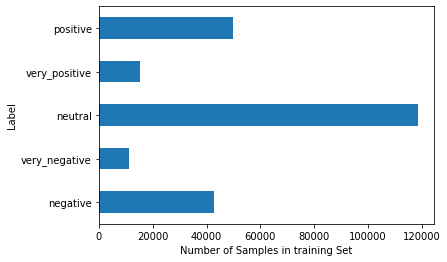

In [305]:
import matplotlib.pyplot as plt
ax = labelled_phrases["sentiment"].value_counts(sort=False).plot(kind="barh")
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

In [306]:
data = pd.read_csv('labelled_phrases.csv')
data = data.drop(columns=['phrase_id', 'sentiment_value'])

In [307]:
#data = data[data.sentiment != 'neutral']

In [308]:
reviews = np.array(data['phrase_tokens'])
sentiments = np.array(data['sentiment'])

# build train and test datasets
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews, sentiments , test_size=0.20,  random_state=0)


In [309]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)


# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (189955, 105660)  Test features shape: (47489, 105660)
TFIDF model:> Train features shape: (189955, 105660)  Test features shape: (47489, 105660)


In [275]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
svm = SGDClassifier(loss='hinge', l1_ratio=0.15, max_iter=1000, n_jobs=4, random_state=101)

In [310]:
def display_classification_report(true_labels, predicted_labels, target_names):

    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
         
        
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)


def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions 


In [311]:
target_names=['very_neg', 'neg', 'neutral', 'pos', 'very_pos']
#target_names=['positive','neagtive']

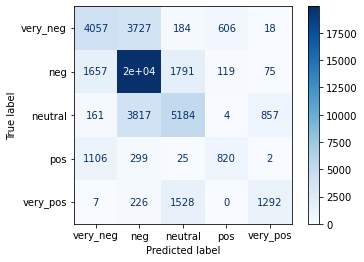

In [312]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
classifier = lr.fit(cv_train_features, train_sentiments)
disp = plot_confusion_matrix(classifier, cv_test_features, test_sentiments,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [233]:
import numpy
temp = []
for i in test_sentiments:
    if i == 'positive':
        temp.append(1)
    else:
        temp.append(0)


In [234]:
test_sentiments_bi = numpy.array(temp)
lr_bow_predictions_bi = numpy.array(temp)


In [232]:
lr_bow_predictions_bi

array([0, 1, 0, ..., 1, 1, 1])

In [277]:
import seaborn as sns

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Logistic Regression ROC')
    target_names=['very_neg', 'neg', 'neutral', 'pos', 'very_pos']
    for i in range(n_classes):
        c = target_names[i]
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(lr,cv_test_features, test_sentiments, n_classes=2, figsize=(16, 10))


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Predict the labels of the test set samples
predicted_labels = classifier.predict(cv_test_features)
# Build the confusion matrix of our 3-class classification problem
cnf_matrix = confusion_matrix(test_sentiments, predicted_labels)


In [250]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)


In [251]:
# Overall Logistic Regression accuracy for binary classification
print('ACC: ', ACC)

ACC:  [0.83642528 0.83642528]


In [147]:
# Overall Logistic Regression accuracy for each class
print('ACC: ', ACC)

ACC:  [0.84278464 0.75339552 0.82381183 0.95449473 0.94287098]


In [ ]:
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr, 
                                         train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                  target_names=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'])

In [293]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()

In [313]:
# RESULTS FOR BINARY CLASSIFICATION
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=rf, 
                                         train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                  target_names=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'])

Model Performance metrics:
------------------------------
Accuracy:  63.87% 
Precision: 62.95% 
Recall:    63.87% 
F1 Score:  63.24% 

Model Classification report:
------------------------------
               precision    recall  f1-score   support

very_negative       0.56      0.50      0.53      8592
     negative       0.72      0.79      0.75     23569
      neutral       0.55      0.52      0.53     10023
     positive       0.47      0.38      0.42      2252
very_positive       0.52      0.45      0.49      3053

     accuracy                           0.64     47489
    macro avg       0.56      0.53      0.54     47489
 weighted avg       0.63      0.64      0.63     47489



In [291]:
svm_bow_predictions = train_predict_model(classifier=lr, 
                                          train_features=cv_train_features[:-37000], train_labels=train_sentiments[:-37000],
                                          test_features=cv_test_features[-37000:], test_labels=test_sentiments[-37000:])
print('SVM results with Bow:')
display_model_performance_metrics(true_labels=test_sentiments[-37000:], predicted_labels=svm_bow_predictions,
                                 target_names=['negative', 'positive'])


svm_tfidf_predictions = train_predict_model(classifier=svm, 
                                            train_features=tv_train_features[:-37000], train_labels=train_sentiments[:-37000],
                                            test_features=tv_test_features[-37000:], test_labels=test_sentiments[-37000:])
print('-'*60)
print('\nSVM results with TF-IDF:')
display_model_performance_metrics(true_labels=test_sentiments[-37000:], predicted_labels=svm_tfidf_predictions,
                                  target_names=['negative', 'positive'])

Logistic Regression:
Model Performance metrics:
------------------------------
Accuracy:  83.22% 
Precision: 83.10% 
Recall:    83.22% 
F1 Score:  82.92% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.84      0.91      0.87     23379
    positive       0.82      0.70      0.76     13621

    accuracy                           0.83     37000
   macro avg       0.83      0.81      0.81     37000
weighted avg       0.83      0.83      0.83     37000

------------------------------------------------------------

SVM results with TF-IDF:
Model Performance metrics:
------------------------------
Accuracy:  73.40% 
Precision: 77.01% 
Recall:    73.40% 
F1 Score:  69.41% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.71      0.97      0.82     23379
    positive       0.87      0.33      0.47     13621

    accurac

In [286]:
svm_bow_predictions = train_predict_model(classifier=svm, 
                                          train_features=cv_train_features, train_labels=train_sentiments,
                                          test_features=cv_test_features, test_labels=test_sentiments)
print('SVM results with Bow:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                 target_names=['negative', 'positive'])


svm_tfidf_predictions = train_predict_model(classifier=svm, 
                                            train_features=tv_train_features, train_labels=train_sentiments,
                                            test_features=tv_test_features, test_labels=test_sentiments)
print('-'*60)
print('\nSVM results with TF-IDF:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                  target_names=['negative', 'positive'])

SVM results with Bow:
Model Performance metrics:
------------------------------
Accuracy:  80.56% 
Precision: 81.36% 
Recall:    80.56% 
F1 Score:  79.47% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.94      0.86     30021
    positive       0.85      0.57      0.68     17468

    accuracy                           0.81     47489
   macro avg       0.82      0.76      0.77     47489
weighted avg       0.81      0.81      0.79     47489

------------------------------------------------------------

SVM results with TF-IDF:
Model Performance metrics:
------------------------------
Accuracy:  73.44% 
Precision: 77.15% 
Recall:    73.44% 
F1 Score:  69.43% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.71      0.97      0.82     30021
    positive       0.87      0.33      0.47     17468

    accura

In [ ]:
# Logistic Regression model on all classes 

lr_bow_predictions = train_predict_model(classifier=lr, 
                                         train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                  target_names=['very_negative', 'negative', 'neutral' 'positive', 'very_positive'])